In [1]:
#import modules
import glob
import tensorflow as tf
import io
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Geting the training data from file

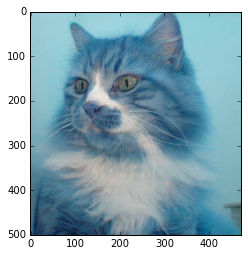

In [2]:
cat_filenames = glob.glob('./train/cat*.jpg')
dog_filenames = glob.glob('./train/dog*.jpg')
image_filenames = glob.glob('./train/*.jpg')
a = cv2.imread(cat_filenames[9], cv2.IMREAD_COLOR)
plt.imshow(a)

### Format inputing images to fit Vgg19 (244,244,3)

In [3]:
def format_images(filelist):
    images = []
    for file in filelist:
        f = cv2.imread(file,cv2.IMREAD_COLOR)
        s = f.shape
        x = s[0]
        y = s[1]
        if max(s) >= 224:
            if x>=y:
                f = cv2.resize(f,(int((y*(224/x))),224))
            else:
                f = cv2.resize(f,(224,int((x*(224/y)))))
        s = f.shape
        x = s[0]
        y = s[1]
        f = cv2.copyMakeBorder(f,224-x,0,224-y,0,cv2.BORDER_CONSTANT,0)
        
        
        images.append(f)
        image = np.array(images)
    return image

In [5]:
#using a 2000 images for training (1000 cats & 1000 dogs)
i = cat_filenames[:1000]+dog_filenames[:1000]
images = format_images(i)

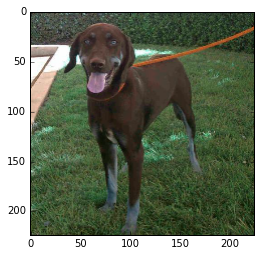

In [36]:
plt.imshow(images[343])
plt.imshow(images[1932])

### Format labels -- One-hot

In [9]:
labels = []
for i in range(2000):
    if i<1000:
        labels.append('cat')
    else:
        labels.append('dog')
label_vec = pd.DataFrame(labels)
label_vec = pd.get_dummies(labels)
label_vec = np.array(label_vec)

### Build pretrained Vgg19 and run dog_cat images on top

In [10]:
import vgg19

batch_size = 50
n_batch = len(label_vec)/batch_size
codes = None



with tf.Session() as sess:
    vgg = vgg19.Vgg19()
    input_ = tf.placeholder(tf.float32,[None,224,224,3])
    with tf.name_scope('vgg_content'):
        vgg.build(input_)
    for i in range(0,label_vec.shape[0],batch_size):
        images_ = (images[i:i+batch_size])/225
        codes_ = sess.run(vgg.relu6,feed_dict ={input_:images_})
        if codes == None:
            codes=codes_
        else:
            codes = np.concatenate((codes,codes_))
        print("{} images processed".format(i))

/Users/ks/Documents/udacity/deep_learning_foundation/dog_cat/vgg19.npy
npy file loaded
build model started
build model finished: 1s
0 images processed


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


50 images processed
100 images processed
150 images processed
200 images processed
250 images processed
300 images processed
350 images processed
400 images processed
450 images processed
500 images processed
550 images processed
600 images processed
650 images processed
700 images processed
750 images processed
800 images processed
850 images processed
900 images processed
950 images processed
1000 images processed
1050 images processed
1100 images processed
1150 images processed
1200 images processed
1250 images processed
1300 images processed
1350 images processed
1400 images processed
1450 images processed
1500 images processed
1550 images processed
1600 images processed
1650 images processed
1700 images processed
1750 images processed
1800 images processed
1850 images processed
1900 images processed
1950 images processed


In [11]:
#write to file
with open ('mini_test_vgg19','w') as f:
    codes.tofile(f)

### Preprocessing training data -- shuffle & split training, validation,testing sets & get batches

In [12]:
from sklearn.model_selection import StratifiedShuffleSplit
ss = StratifiedShuffleSplit(n_splits = 3,test_size = 0.2)
train_idx,test_idx = next(ss.split(codes,label_vec))
X_train,y_train = codes[train_idx],label_vec[train_idx]
v_t = int(len(test_idx)/2)
X_val, y_val = codes[test_idx[:v_t]],label_vec[test_idx[:v_t]]
X_test,y_test = codes[test_idx[v_t:]],label_vec[test_idx[v_t:]]

In [13]:
def get_batch(x,y,n_batch):
    batch_size = len(x)//n_batch
    x,y = x[:(n_batch*batch_size)],y[:(n_batch*batch_size)]
    for i in range(0,n_batch*batch_size,batch_size):
        a,b = x[i:i+batch_size],y[i:i+batch_size]
    yield a,b

### Build 

In [14]:
inputs = tf.placeholder(tf.float32,[None,X_train.shape[1]])
labels = tf.placeholder(tf.float32,[None,label_vec.shape[1]])

fc = tf.contrib.layers.fully_connected(inputs,256,activation_fn = None)

logits = tf.contrib.layers.fully_connected(fc,label_vec.shape[1],activation_fn = None)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits = logits))

optimizer = tf.train.AdamOptimizer().minimize(loss)

prediction = tf.nn.softmax(logits)
correct_pred = tf.equal(tf.argmax(prediction,1),tf.argmax(labels,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

### Train

In [15]:
epoches = 10
steps= 0
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epoches):
        for x,y in get_batch(X_train,y_train,10):
            loss_,_ = sess.run([loss,optimizer],feed_dict = {inputs:x,labels:y})
            print ('Epoch {}/{}'.format(e,epoches),
                  'Step {}'.format(steps),
                  'Loss {:.3f}'.format(loss_))
            steps +=1
        acu = sess.run(accuracy,feed_dict ={inputs:X_val,labels:y_val})
        print ('Epoch {}/{}'.format(e,epoches),
              'Step {}'.format(steps),
               'Validation Accuracy {:.4f}'.format(acu))
        
        saver.save(sess, "checkpoints/mini_test.ckpt")
                

Epoch 0/10 Step 0 Loss 3.694
Epoch 0/10 Step 1 Validation Accuracy 0.5000
Epoch 1/10 Step 1 Loss 36.825
Epoch 1/10 Step 2 Validation Accuracy 0.6150
Epoch 2/10 Step 2 Loss 15.700
Epoch 2/10 Step 3 Validation Accuracy 0.8950
Epoch 3/10 Step 3 Loss 1.273
Epoch 3/10 Step 4 Validation Accuracy 0.9550
Epoch 4/10 Step 4 Loss 0.456
Epoch 4/10 Step 5 Validation Accuracy 0.9250
Epoch 5/10 Step 5 Loss 2.906
Epoch 5/10 Step 6 Validation Accuracy 0.9150
Epoch 6/10 Step 6 Loss 4.526
Epoch 6/10 Step 7 Validation Accuracy 0.9050
Epoch 7/10 Step 7 Loss 4.778
Epoch 7/10 Step 8 Validation Accuracy 0.9200
Epoch 8/10 Step 8 Loss 3.846
Epoch 8/10 Step 9 Validation Accuracy 0.9250
Epoch 9/10 Step 9 Loss 2.320
Epoch 9/10 Step 10 Validation Accuracy 0.9250


### Testing with test set

In [16]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs: X_test,
            labels: y_test}
    test_acc = sess.run(accuracy, feed_dict=feed)
    print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.9850


### Test with some fun images

In [18]:
test_set = glob.glob('./test*.jpg')

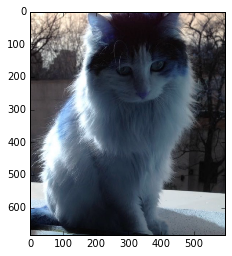

In [20]:
#a = cv2.imread('./train/dog.5633.jpg', cv2.IMREAD_COLOR)
a = cv2.imread(test_set[5],cv2.IMREAD_COLOR)
plt.imshow(a)

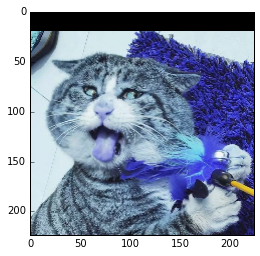

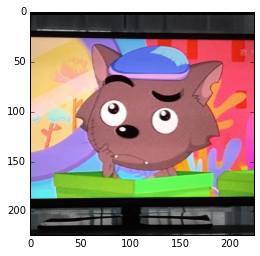

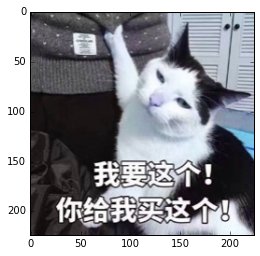

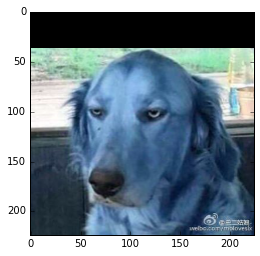

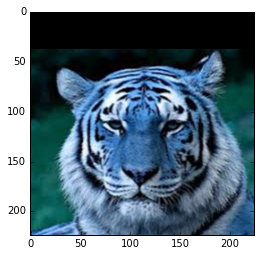

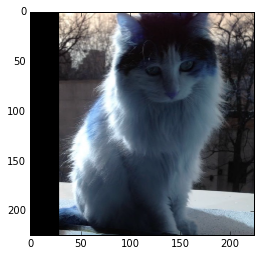

In [27]:
test_img = format_images(test_set)
for img in test_img:
    plt.figure()
    plt.imshow(img)

In [23]:
with tf.Session() as sess:
    code_test = sess.run(vgg.relu6,feed_dict = {input_:test_img})
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    feed = {inputs: code_test}
    pred = sess.run(prediction, feed_dict=feed).squeeze()

In [32]:
def get_prediction(pred):
    return pd.DataFrame(pred,columns=['Cat','Dog'])

In [33]:
get_prediction(pred)

,Cat,Dog
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,0.0,1.0
4,1.0,0.0
5,1.0,0.0
